In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import ast
import string
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
df = pd.read_csv('TKlemm0409v2.csv')

In [3]:
def load_stopwords():
    filepath = 'polish.stopwords.txt'
    with open(filepath, 'r', encoding='utf-8') as f:
        stopwords = set(line.strip().lower() for line in f if line.strip())
    return stopwords

def clean_tokens(tokens):
    stop_words = load_stopwords()
    replacements = {
        'ipna': 'IPN',
        'vot': 'vat'                        
    }
    cleaned = []
    for token in tokens:
        token_lower = token.lower()
        if token_lower in stop_words:
            continue
        if token_lower in string.punctuation:
            continue
        if token_lower.isdigit():
            continue
        if any(char.isdigit() for char in token_lower):
            continue
        # Zamiana słowa, jeśli jest w słowniku replacements
        token_replaced = replacements.get(token_lower, token_lower)
        cleaned.append(token_replaced)
    return cleaned

In [4]:
df['grounds_lem'] = df['grounds_lem'].apply(ast.literal_eval)
df['grounds_lem_cleaned'] = df['grounds_lem'].apply(clean_tokens)

In [5]:
docs = df['grounds_lem_cleaned'].apply(lambda tokens: ' '.join(tokens)).tolist()
tfidf = TfidfVectorizer(
    smooth_idf=True, 
    use_idf=True,
    min_df = 5,
    max_df = 0.95,
    max_features=10000,
    ngram_range=(1,2)
)
tfidf.fit(docs)
text = tfidf.transform(docs)

In [ ]:
def avg_len(docs):
    n = len(docs)
    suma = 0
    for i in range(n):
        suma += len(docs[i])
    return suma / n

35723.653386454185


In [8]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sil_scores = []
    for k in iters:
        km = MiniBatchKMeans(n_clusters=k, random_state=42)
        labels = km.fit_predict(data)
        sil_scores.append(silhouette_score(data, labels))
    
    plt.plot(iters, sil_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method For Optimal k')
    plt.show()

In [43]:
clusters = MiniBatchKMeans(n_clusters=10, random_state=32).fit_predict(text)

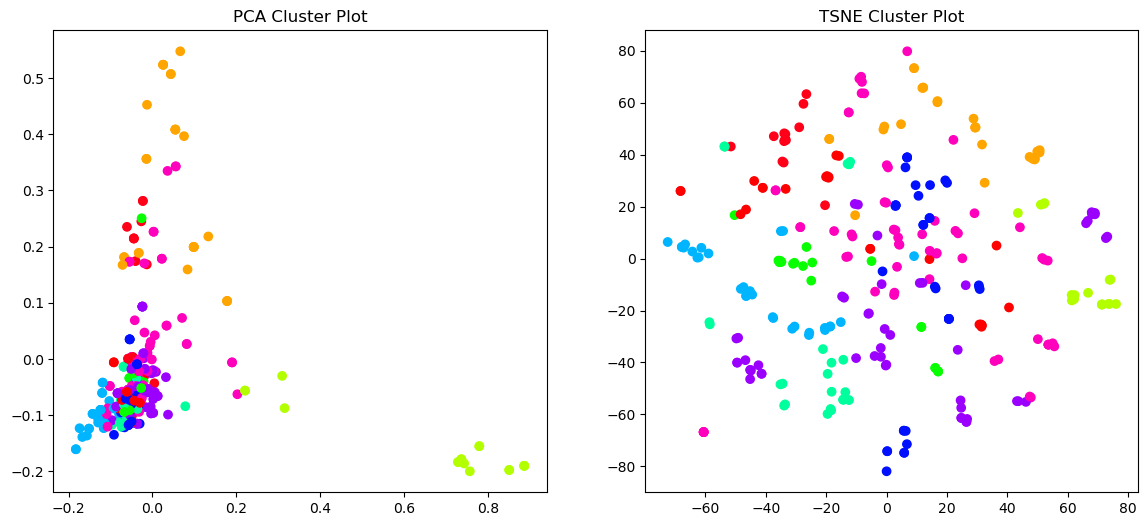

In [45]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:])
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:]))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text, clusters)

In [47]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names_out(), 5)


Cluster 0
osoba,sąd,policja,funkcjonariusz,służba

Cluster 1
samorząd terytorialny,nieruchomość,terytorialny,samorząd,gmina

Cluster 2
członek spółdzielnia,spółdzielnia mieszkaniowy,mieszkaniowy,spółdzielnia,lokal

Cluster 3
opieka zdrowotny,opieka,medyczny,zawód,zdrowotny

Cluster 4
informacja,poprawka,dokument,lustracyjny,ipn

Cluster 5
ordynacja podatkowy,vat,podatnik,podatek,podatkowy

Cluster 6
zasada,emerytura,pracodawca,pracownik,praca

Cluster 7
wnioskodawca,sędzia,rada,kas,sąd

Cluster 8
ochrona,rozporządzenie,osoba,publiczny,zasada

Cluster 9
europejski,ordynacja,republika,wybory,wyborczy


In [31]:
def get_top_keywords_from_svd(svd_model, feature_names, n_terms=10):
    for i, comp in enumerate(svd_model.components_):
        terms = [feature_names[i] for i in np.argsort(comp)[-n_terms:]]
        print(f"\nTemat {i+1}: {', '.join(terms)}")

In [ ]:
get_top_keywords_from_svd(svd, tfidf.get_feature_names_out(), 10)